In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepc as qem

Cost after step     5:  1.0524115
Cost after step    10:  0.3700231
Cost after step    15:  0.1153734
Cost after step    20:  0.0649767
Cost after step    25:  0.1098320
Cost after step    30:  0.0382214
Cost after step    35:  0.0991508
Cost after step    40:  0.0440037
Cost after step    45:  0.0325552
Cost after step    50:  0.0976168
Cost after step    55:  0.0414722
Cost after step    60:  0.0721546
Cost after step    65:  0.0244484
Cost after step    70:  0.0986249
Cost after step    75:  0.0194773
Cost after step    80:  0.0175721
Cost after step    85:  0.0296573
Cost after step    90:  0.0183064
Cost after step    95:  0.0875606
Cost after step   100:  0.0652648
Optimized rotation angles: [[[ 0.55246227  1.52806015  0.04608693]
  [ 0.64525183  2.08089039 -0.34221416]]

 [[ 0.34551444  1.06020006  0.49440365]
  [ 0.97921826  0.17139506  0.50006304]]]


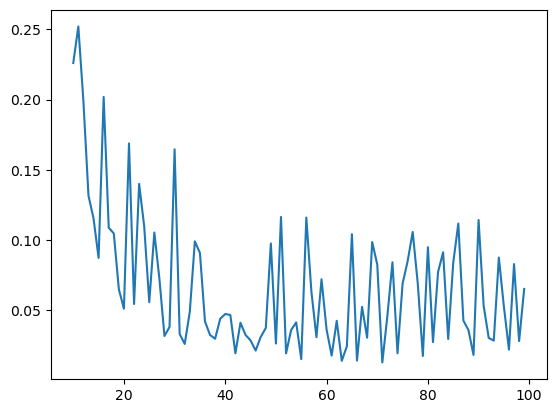

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
nqubitsdepolarizingchannel = nqubitschannel.nqubitsdepolarizingchannel(0.9)

@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (train_cir_without_qem(x) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

Cost after step     5:  0.8017615
Cost after step    10:  0.3522266
Cost after step    15:  0.2005618
Cost after step    20:  0.1396153
Cost after step    25:  0.1105104
Cost after step    30:  0.0948200
Cost after step    35:  0.0856558
Cost after step    40:  0.0800136
Cost after step    45:  0.0764160
Cost after step    50:  0.0740677
Cost after step    55:  0.0725103
Cost after step    60:  0.0714663
Cost after step    65:  0.0707613
Cost after step    70:  0.0702827
Cost after step    75:  0.0699568
Cost after step    80:  0.0697342
Cost after step    85:  0.0695820
Cost after step    90:  0.0694777
Cost after step    95:  0.0694063
Cost after step   100:  0.0693573
Optimized rotation angles: [[[0.2919585  0.21127984 0.88060419]
  [0.83672608 3.12100387 0.6098175 ]]

 [[0.52497723 0.01259822 0.80819048]
  [0.6118058  0.99626694 0.3896053 ]]]


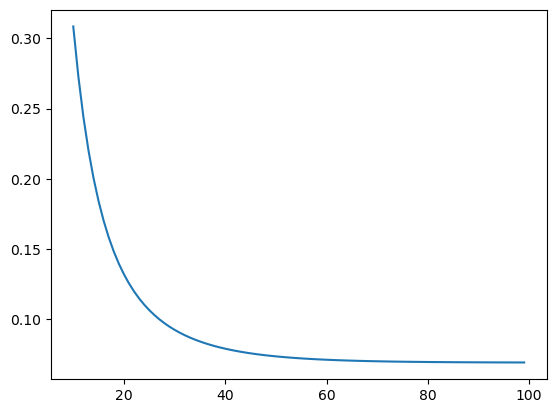

In [3]:
# We set the noise channel as time-invariant and observe the results again.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
nqubitsdepolarizingchannel = nqubitschannel.nqubitsdepolarizingchannel(0.9)

@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (train_cir_without_qem(x) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [4]:
# We estimate the total noise 'p_t' using the QEMZMSEPC method,
# allowing us to incorporate noise 'p_t' into the definition of the Loss function,
# thereby mitigating the impact of noise on quantum machine learning tasks.

operations = ['RX', 'RY', 'RZ', 'RX', 'RY', 'RZ', 'CNOT', 'CNOT',
              'RX', 'RY', 'RZ', 'RX', 'RY', 'RZ', 'CNOT', 'CNOT']
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)
w = weights.copy().reshape(-1)
paras = [[0, w[0]], [0, w[1]], [0, w[2]], [0, w[3]], [0, w[4]], [0, w[5]], [0, 1], [1, 0],
     [0, w[6]], [0, w[7]], [0, w[8]], [0, w[9]], [0, w[10]], [0, w[11]], [0, 1], [1, 0]]
qemzmsepc = qem.QEMZMSEPC(n_qubits)
_, p_t = qemzmsepc.qemzmsepc(operations=operations, paras=paras, dev=dev, p=0.9,
                         kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
print(p_t)

0.7368461448730742


Cost after step     5:  0.3873259
Cost after step    10:  0.0963935
Cost after step    15:  0.0413047
Cost after step    20:  0.0227317
Cost after step    25:  0.0143634
Cost after step    30:  0.0098988
Cost after step    35:  0.0072396
Cost after step    40:  0.0055282
Cost after step    45:  0.0043619
Cost after step    50:  0.0035311
Cost after step    55:  0.0029182
Cost after step    60:  0.0024530
Cost after step    65:  0.0020915
Cost after step    70:  0.0018049
Cost after step    75:  0.0015738
Cost after step    80:  0.0013847
Cost after step    85:  0.0012280
Cost after step    90:  0.0010966
Cost after step    95:  0.0009854
Cost after step   100:  0.0008904
Optimized rotation angles: [[[0.4968178  0.57377272 0.55980519]
  [0.29544869 0.12940784 0.48083874]]

 [[0.60848746 2.90357049 0.81888524]
  [0.76697865 0.93633514 0.09027793]]]


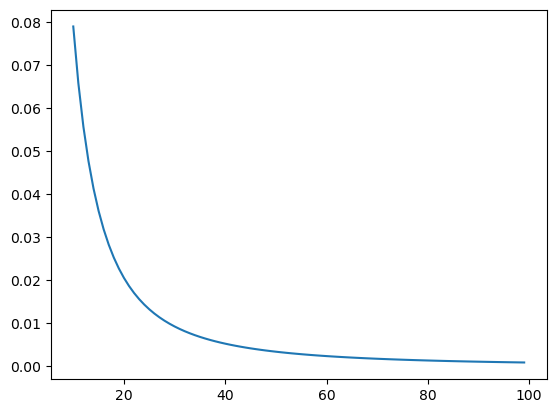

In [5]:
@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

# We modify the definition of the Loss function
# by dividing the output of the quantum circuit by the noise parameter p_t
# to obtain the expected output of the quantum circuit after error mitigation,
# and then proceed with the Loss calculation.

def cost(x):
    return ((train_cir_with_qem(x) / p_t) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []
qemzmsepc = qem.QEMZMSEPC(n_qubits)

for i in range(steps):
    params = opt.step(cost, params)
    w = params.copy().reshape(-1)
    paras = [[0, w[0]], [0, w[1]], [0, w[2]], [0, w[3]], [0, w[4]], [0, w[5]], [0, 1], [1, 0],
         [0, w[6]], [0, w[7]], [0, w[8]], [0, w[9]], [0, w[10]], [0, w[11]], [0, 1], [1, 0]]
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    _, p_t = qemzmsepc.qemzmsepc(operations=operations, paras=paras, dev=dev, p=0.9,
                             kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))
import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [6]:
# From the results, we can observe that the Loss function exhibits a stable decreasing trend
# after error mitigation through the QEMZMSEPC scheme,
# and ultimately, the outcome is better than without error mitigation.